# Importing all Libraries

In [27]:
import cv2 as cv
import tensorflow as tf
from os import listdir
import os
from matplotlib import image
import matplotlib.patches as mpatches
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from PIL import Image

# HOUGH Circle Detection

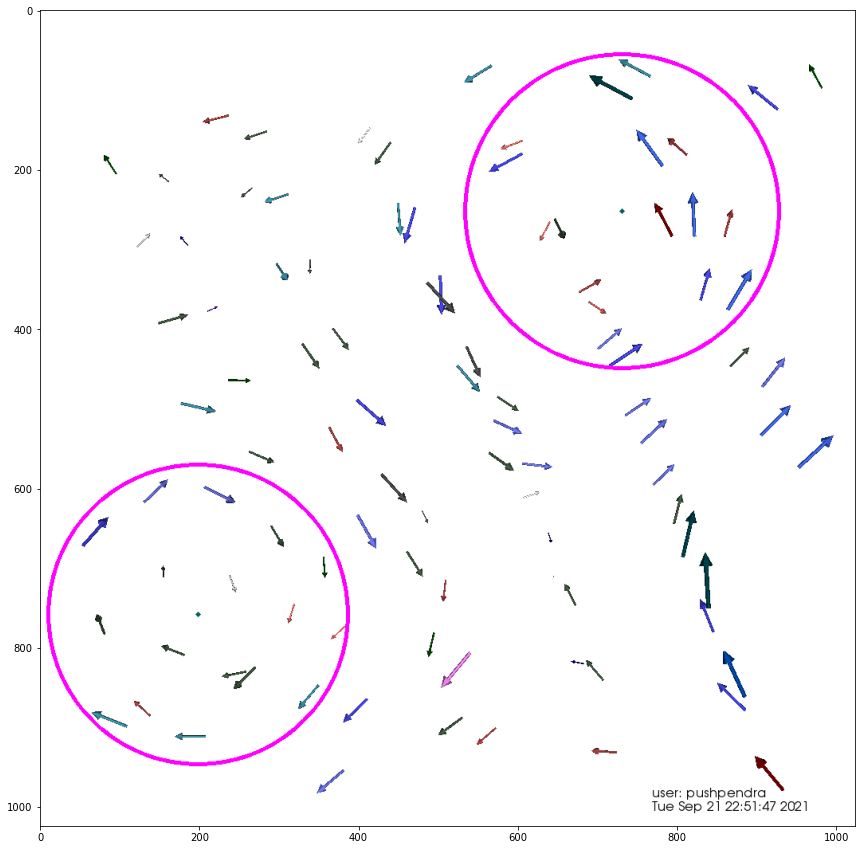

In [28]:
img=cv.imread('/home/subhodeep/Documents/IIIT_Bangalore/Sem_3_2021/PE/Project/vectored_image_generation/visit_images/visit0001.png')
img1=cv.imread('/home/subhodeep/Documents/IIIT_Bangalore/Sem_3_2021/PE/Project/vectored_image_generation/visit_images_2/visit0001.png')

gray=cv.cvtColor(img,cv.COLOR_BGR2GRAY)
blur = cv.GaussianBlur(gray,(9,9),10)

ret,thresh = cv.threshold(blur,127,255,cv.THRESH_TRUNC)

rows = thresh.shape[0]
circles = cv.HoughCircles(thresh, cv.HOUGH_GRADIENT, 1, rows /4, param1=50, param2=50, minRadius=150, maxRadius=200)

all_circles = [] # stores vortex podition and radius

if circles is not None:
    circles = np.uint16(np.around(circles))
    #print(len(circles[0, :]))
    for i in circles[0, :]:
        center = (i[0], i[1])
        # circle center
        cv.circle(img1, center, 1, (0, 100, 100), 3)
            # circle outline
        x, y, r = i[0],i[1],i[2]
        all_circles.append([[x,y],r])
        #print(x,y,r)
        #crop_image = img1[y-side:y+side, x-side:x+side]
        #img_name = 'cropped/'+str(x)+'_'+str(y)+'_'+str(r)+'.png'
        #cv.imwrite(img_name,crop_image)
        cv.circle(img1, center, r, (255, 0, 255), 3)

plt.figure(figsize = (15,15))
imgplot = plt.imshow(img1)


# Crop All Vectors

In [29]:
def get_objects(image,name):
    
    gray=cv.cvtColor(image,cv.COLOR_BGR2GRAY)

    edged = cv.Canny(image, 10, 250)

    (_, cnts, _) = cv.findContours(edged.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    dir = "/home/subhodeep/Documents/IIIT_Bangalore/Sem_3_2021/PE/Project/CNN_Model/Test/"
    
    idx = 0
    for c in cnts:
        x,y,w,h = cv.boundingRect(c)
        if w>15 and h>15:
            idx+=1
            new_img=image[y:y+h,x:x+w]
            #cropping images
            cv.imwrite(dir+name+'_'+str(idx)+ '.png', new_img)
    #cv2.imshow("Original Image",image)
    #cv2.imshow("Canny Edge",edged)


In [30]:
def crop_objects(img):
    height, width = img.shape[0], img.shape[1]
    #print(height,width)
    n1, n2 = ['top','bottom'], ['left','right']

    img1 = img[0:height//2, 0:width//2]
    img2 = img[0:height//2, width//2:width]
    img3 = img[height//2:height, 0:width//2]
    img4 = img[height//2:height, width//2:width]
    image = [img1,img2,img3,img4]

    j, k = 0, 0
    
    # Vectors are cropped as per their positions (top-left or bottom-right or ...)
    for i in range(1,5):
        if k==2:
            j += 1
            k = 0
        #print(j,k)
        name = n1[j]+'_'+n2[k]
        k += 1
        get_objects(image[i-1],name)
    
    #print("Image cropped successful")


# Delete Images from a Directory 

In [31]:
def remove_objects():
    dir = '/home/subhodeep/Documents/IIIT_Bangalore/Sem_3_2021/PE/Project/CNN_Model/Test'
    
    for f in os.listdir(dir):
        os.remove(os.path.join(dir, f))


# Test CNN And Detect Direction of Vectors

In [32]:
def prepare(file):
    IMG_SIZE = 80
    img_array = cv.imread(file, cv.IMREAD_GRAYSCALE)
    new_array = cv.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [33]:
def test_results():
    data = []

    for filename in listdir('Test'):
        img_dir = 'Test/' + filename
        img = prepare(img_dir)
        img_data = Image.open(img_dir)
        prediction = model.predict([img])
        prediction = list(prediction[0])
        name = CATEGORIES[prediction.index(max(prediction))]
        data.append([filename,name])
    
    return data


# Detect The Orientation of Vectors

In [34]:
def detect_rotation(data):
    clock_count, anticlock_count = 0, 0
    for i in range(len(data)):
        img_name = data[i][0]
        direction = data[i][1]
        ps = img_name.split("_")
        position = ps[0]+'-'+ps[1]
        if position=="bottom-right":
            if direction=="left" or direction=="down":
                clock_count += 1
            else:
                anticlock_count += 1
        elif position=="bottom-left":
            if direction=="left" or direction=="up":
                clock_count += 1
            else:
                anticlock_count += 1
        elif position=="top-left":
            if direction=="right" or direction=="up":
                clock_count += 1
            else:
                anticlock_count += 1
        elif position=="top-right":
            if direction=="right" or direction=="down":
                clock_count += 1
            else:
                anticlock_count += 1
    return [clock_count,anticlock_count]

In [35]:
def prediction(data):
    cl_c, acl_c = detect_rotation(data)
    #print(cl_c,acl_c)

    if cl_c>acl_c:
        return "Clockwise"
    elif cl_c<acl_c:
        return "Anticlockwise"
    else:
        return "Can't Predict"

# Integration

In [36]:
CATEGORIES = ["left","right","up","down"]

model = tf.keras.models.load_model('CNN.model')

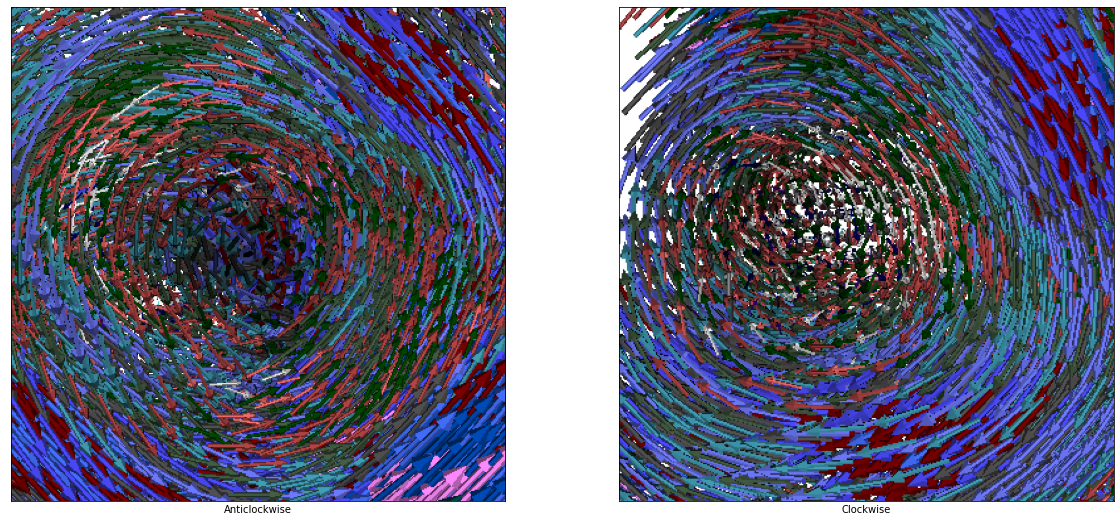

In [37]:
#print(all_circles)
i = 0
plt.figure(figsize=(20,20))

details = []

# Predicting all the detected vortex rotation 
for i in range(len(all_circles)):
    curr = all_circles[i]
    x, y, r = curr[0][0], curr[0][1], curr[1]
    img=cv.imread('/home/subhodeep/Documents/IIIT_Bangalore/Sem_3_2021/PE/Project/vectored_image_generation/visit_images/visit0001.png')
    img1=cv.imread('/home/subhodeep/Documents/IIIT_Bangalore/Sem_3_2021/PE/Project/vectored_image_generation/visit_images_2/visit0001.png')
    
    # cropped the vortex position from both original and 200 vector image
    crop_image = img1[y-r:y+r, x-r:x+r]
    cropped_image = img[y-r:y+r, x-r:x+r]
    
    # cropped all vectors from the vortex and stores them in Test file
    crop_objects(crop_image)
    
    # Detect and predict the rotation of vectors
    direction = test_results()
    predicted_result = prediction(direction)
    
    # Getting Details of all vortex 
    details.append([x,y,r,predicted_result])
    
    # Plot the rotation with the vortex image
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cropped_image)
    plt.xlabel(predicted_result)

    i = i+1
    
    #print(predicted_result)
    
    # Delete all Vectors from Test file
    remove_objects()
    

# Visualization of Vortices

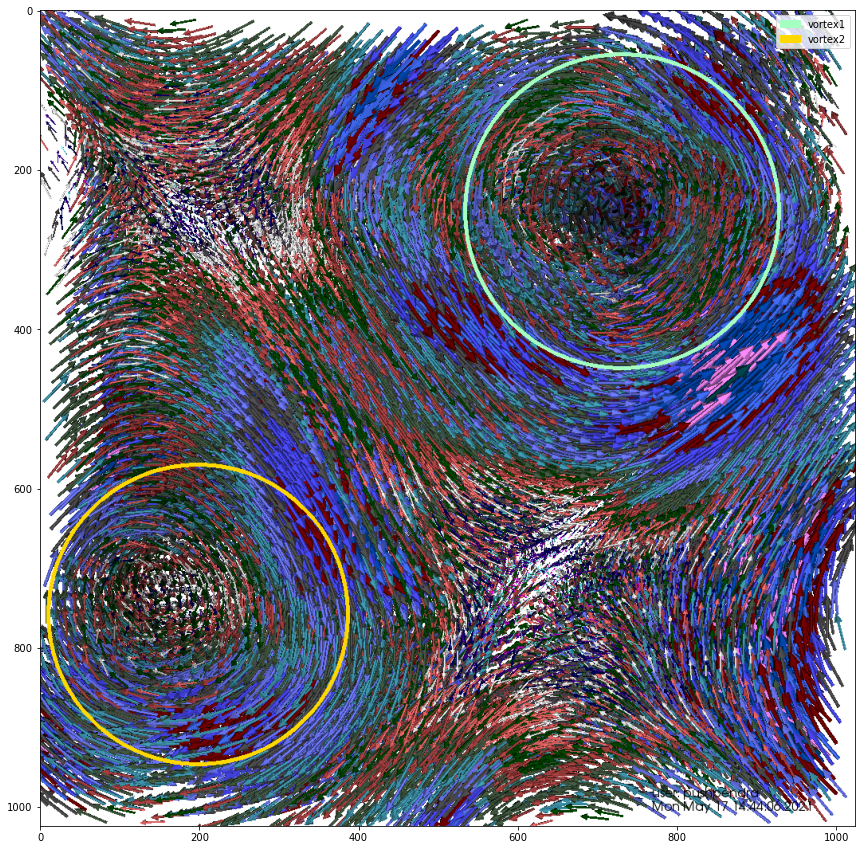

In [38]:
patches = []

colors = [[164,255,192],[255,216,0],[242,255,164],[251,206,226],[206,237,251]]

for i in range(len(details)):
    x, y, ra = details[i][0], details[i][1], details[i][2]
    r, g, b = colors[i][0], colors[i][1], colors[i][2]
    cv.circle(img, (x,y), ra, (r,g,b), 3)
    name = 'vortex'+str(i+1)
    patch = mpatches.Patch(color=(r/255,g/255,b/255), label=name)
    patches.append(patch)

plt.figure(figsize = (15,15))
imgplot = plt.imshow(img)
plt.legend(handles=patches, loc="upper right")

# Details of All Votices

In [39]:
for i in range(len(details)):
    print("Image Name : Vortex",i+1)
    print("Position : (x,y) =>","(",details[i][0],",",details[i][1],")")
    print("Direction :",details[i][3])
    print()

Image Name : Vortex 1
Position : (x,y) => ( 730 , 252 )
Direction : Anticlockwise

Image Name : Vortex 2
Position : (x,y) => ( 198 , 758 )
Direction : Clockwise

